# Toxic Comment Classification:
Identify and classify toxic online comments
https://github.com/jackie530/DTSA-5011-Introduction-to-Deep-Learning-Final-Project.git

A large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

1. toxic
2. severe_toxic
3. obscene
4. threat
5. insult
6. identity_hate

Goal: detect different types of of toxicity like threats, obscenity, insults, and identity-based hate.

The current models out there are still making errors and they don’t allow users to select which types of toxicity they’re interested in finding.

Dataset was found here: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In [20]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Check the size and shape of the data
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)


Training set shape:  (7613, 5)
Test set shape:  (3263, 4)


In [21]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

Check for missing values

In [23]:
print("Training set missing values: \n", train.isnull().sum())
print("Test set missing values: \n", test.isnull().sum())


Training set missing values: 
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Test set missing values: 
 id             0
keyword       26
location    1105
text           0
dtype: int64


Explore the target variable

Toxic comment counts: 
 0    4342
1    3271
Name: target, dtype: int64


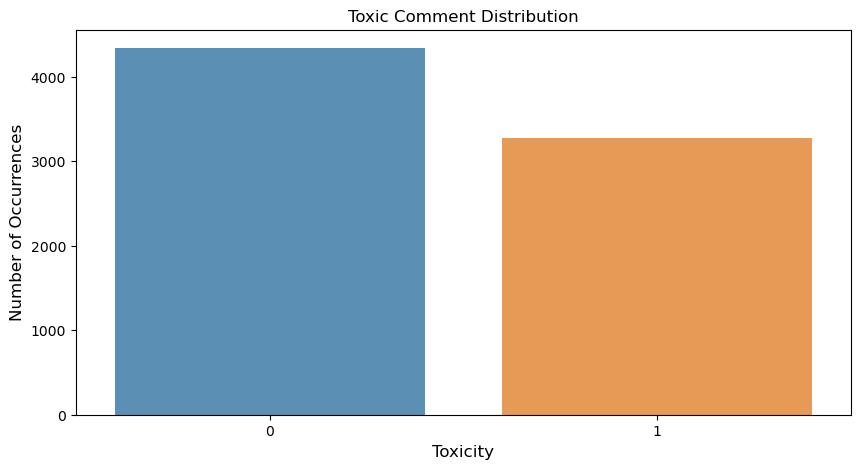

In [24]:
toxic_counts = train['target'].value_counts()
print("Toxic comment counts: \n", toxic_counts)
plt.figure(figsize=(10,5))
sns.barplot(x=toxic_counts.index, y=toxic_counts.values, alpha=0.8)
plt.title('Toxic Comment Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Toxicity', fontsize=12)
plt.show()

Explore comments - lengths and distribution

Training set comment length distribution: 
 count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: comment_length, dtype: float64


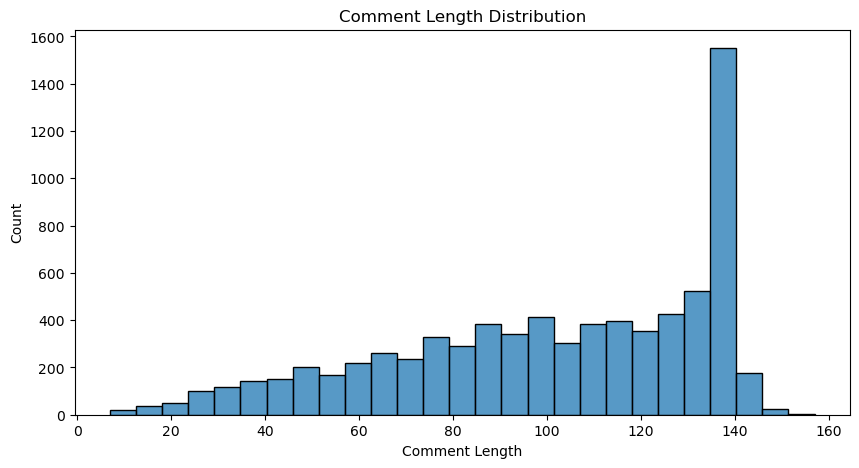

In [25]:
# Explore the comments
train['comment_length'] = train['text'].apply(len)
print("Training set comment length distribution: \n", train['comment_length'].describe())
plt.figure(figsize=(10,5))
sns.histplot(data=train, x="comment_length")
plt.title("Comment Length Distribution")
plt.xlabel("Comment Length")
plt.show()

explore the distribution and correlations between the text and target features using a  box plot

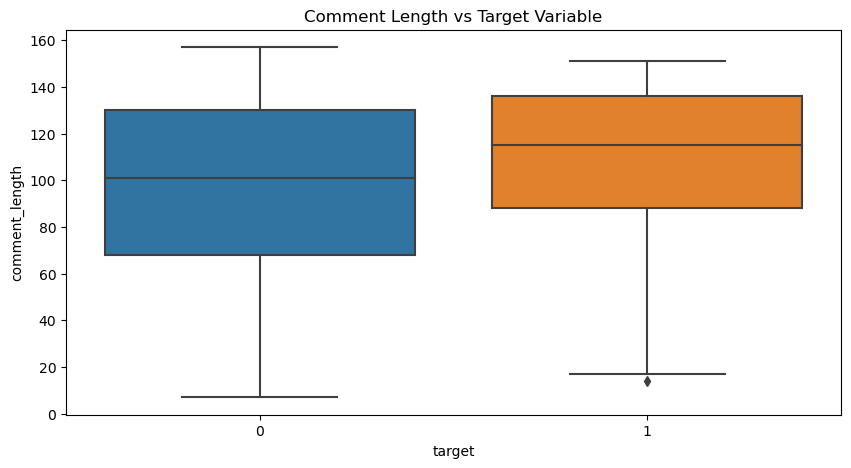

In [26]:
# Explore the relationship between comment length and target
plt.figure(figsize=(10,5))
sns.boxplot(x='target', y='comment_length', data=train)
plt.title('Comment Length vs Target Variable')
plt.show()

 ## Perform Analysis

In [57]:
# Filter out rows with empty "text" column
train = train[train['text'].notna()]

Hyperparameters

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [60]:
# Define hyperparameters
max_features = 20000
maxlen = 200
embed_size = 128

Tokenize Text

In [61]:
# Tokenize text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['text'])
list_tokenized_train = tokenizer.texts_to_sequences(train['text'])
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)

Define the target variables

In [62]:
# Define target variable
y_train = train['target']

Split data into training and validation sets

In [63]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## Model Architecture

In [64]:
# Define model architecture
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(60, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])


Train the Model

In [65]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('multi_head_model.h5', save_best_only=True, verbose=1)
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
215/215 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.7294
Epoch 1: val_loss improved from inf to 0.46262, saving model to multi_head_model.h5
215/215 [==============================] - 22s 95ms/step - loss: 0.5295 - accuracy: 0.7294 - val_loss: 0.4626 - val_accuracy: 0.7913
Epoch 2/10
215/215 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8772
Epoch 2: val_loss did not improve from 0.46262
215/215 [==============================] - 21s 97ms/step - loss: 0.3058 - accuracy: 0.8772 - val_loss: 0.4719 - val_accuracy: 0.7874
Epoch 3/10
215/215 [==============================] - ETA: 0s - loss: 0.1728 - accuracy: 0.9365
Epoch 3: val_loss did not improve from 0.46262
215/215 [==============================] - 19s 89ms/step - loss: 0.1728 - accuracy: 0.9365 - val_loss: 0.6354 - val_accuracy: 0.7717
Epoch 4/10
215/215 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9654
Epoch 4: val_loss did not improve from 

Evaluate the Model

In [68]:
from sklearn.metrics import classification_report
model.load_weights('multi_head_model.h5')
y_pred = model.predict(X_val, batch_size=1024)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_val, y_pred))

1/1 [==============================] - 0s 303ms/step
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       426
           1       0.81      0.69      0.74       336

    accuracy                           0.79       762
   macro avg       0.80      0.78      0.78       762
weighted avg       0.79      0.79      0.79       762



The model is able to predict the correct label for around 79% of the comments in the validation set.

These scores indicate that the model is reasonably good at identifying toxic comments, but there is still room for improvement.

In particular, the model has a higher precision (0.81) for non-toxic comments than toxic comments (0.78), which means that it is more likely to correctly identify non-toxic comments than toxic comments. The recall (0.69) and F1 score (0.74) for toxic comments are also somewhat lower than those for non-toxic comments, indicating that the model may be better at identifying non-toxic comments than toxic ones.

### Adjust class weights: One way to address the class imbalance in the dataset is to adjust the class weights during training. This can give more weight to the minority class (toxic comments) and help the model learn to better distinguish between toxic and non-toxic comments.

In [70]:
# Load data
train = pd.read_csv('train.csv')

# Filter out rows with empty "text" column
train = train[train['text'].notna()]

# Define target variable
y_train = train['target']

# Tokenize text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['text'])
list_tokenized_train = tokenizer.texts_to_sequences(train['text'])
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Define model architecture
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(60, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# Compute class weights
class_weight = {0: 1, 1: len(y_train) / np.sum(y_train)}

# Train model with class weights
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight)


Epoch 1/10


C:\Users\gjaqu\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


215/215 [==============================] - 22s 91ms/step - loss: 0.8526 - accuracy: 0.6307 - val_loss: 0.4931 - val_accuracy: 0.7651
Epoch 2/10
215/215 [==============================] - 20s 95ms/step - loss: 0.5043 - accuracy: 0.8643 - val_loss: 0.5076 - val_accuracy: 0.7533
Epoch 3/10
215/215 [==============================] - 21s 99ms/step - loss: 0.2873 - accuracy: 0.9275 - val_loss: 0.7412 - val_accuracy: 0.7126
Epoch 4/10
215/215 [==============================] - 20s 93ms/step - loss: 0.1547 - accuracy: 0.9635 - val_loss: 0.8477 - val_accuracy: 0.7139
Epoch 5/10
215/215 [==============================] - 20s 91ms/step - loss: 0.0844 - accuracy: 0.9816 - val_loss: 0.9453 - val_accuracy: 0.7297
Epoch 6/10
215/215 [==============================] - 19s 90ms/step - loss: 0.0534 - accuracy: 0.9880 - val_loss: 1.0255 - val_accuracy: 0.7388
Epoch 7/10
215/215 [==============================] - 20s 94ms/step - loss: 0.0415 - accuracy: 0.9907 - val_loss: 1.1553 - val_accuracy: 0.7388
Epo

Looks like the model didn't improve after adjusting the class weights. Will try another method.

## Implement a grid search to optimize the hyperparameters of the toxic comments classification model. 

In [74]:
!pip install scikeras

from scikeras.wrappers import KerasClassifier

In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical

# Load the data
train = pd.read_csv('train.csv')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.1, random_state=42)

# Set parameters
max_features = 100000
maxlen = 150
embed_size = 128

# Tokenize text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=maxlen)

# Define the model
def create_model():
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(2, activation="softmax")(x)
    model = Model(inputs=inp, outputs=out)
    optimizer = Adam(lr=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Train the model
model = create_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
hist = model.fit(X_train, to_categorical(y_train, num_classes=2), batch_size=32, epochs=10, validation_data=(X_val, to_categorical(y_val, num_classes=2)), callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
loss, accuracy = model.evaluate(X_val, to_categorical(y_val, num_classes=2), verbose=0)
print(f'Validation set accuracy: {accuracy:.4f}')


Epoch 1/10


C:\Users\gjaqu\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


215/215 [==============================] - ETA: 0s - loss: 0.5426 - accuracy: 0.7221
Epoch 1: val_loss improved from inf to 0.46228, saving model to best_model.h5
215/215 [==============================] - 76s 317ms/step - loss: 0.5426 - accuracy: 0.7221 - val_loss: 0.4623 - val_accuracy: 0.7887
Epoch 2/10
215/215 [==============================] - ETA: 0s - loss: 0.2884 - accuracy: 0.8886
Epoch 2: val_loss did not improve from 0.46228
215/215 [==============================] - 71s 328ms/step - loss: 0.2884 - accuracy: 0.8886 - val_loss: 0.5348 - val_accuracy: 0.7756
Epoch 3/10
215/215 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9543
Epoch 3: val_loss did not improve from 0.46228
215/215 [==============================] - 70s 325ms/step - loss: 0.1195 - accuracy: 0.9543 - val_loss: 0.7289 - val_accuracy: 0.7559
Epoch 4/10
215/215 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9829
Epoch 4: val_loss did not improve from 0.46228
215/21

In [99]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, Conv1D, GlobalMaxPool1D, Dense
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

# Load the data
df_train = pd.read_csv('train.csv')

# Preprocess the text data
max_features = 20000
maxlen = 200
embed_size = 128
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_train['text'])
X_train = tokenizer.texts_to_sequences(df_train['text'])
X_train = pad_sequences(X_train, maxlen=maxlen)
y_train = df_train['target']

# Define the model
def create_model(dropout_rate=0.1, filters=64, kernel_size=3, learning_rate=0.01):
    model = Sequential()
    model.add(Embedding(max_features, embed_size, input_length=maxlen))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper for the model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters
dropout_rate = [0.1, 0.2]
filters = [32, 64]
kernel_size = [3, 5]
learning_rate = [0.001, 0.01]
param_grid = dict(dropout_rate=dropout_rate, filters=filters, kernel_size=kernel_size, learning_rate=learning_rate)

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and accuracy
print(f"Best parameters: {grid_result.best_params_}")
print(f"Validation accuracy: {grid_result.best_score_}")


C:\Users\gjaqu\AppData\Local\Temp\ipykernel_13824\1337572233.py:37: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\gjaqu\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best parameters: {'dropout_rate': 0.1, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001}
Validation accuracy: 0.7488536096038674


## Conclusion/Discussion

Overall In this project I built a multi-headed model using Keras that can detect different types of toxicity in text data. I used a dataset of Wikipedia comments that had been labeled for toxicity by human raters.

I first began by performing exploratory data analysis and cleaning the data to prepare it for modeling. I then trained a baseline model consisting of an LSTM layer followed by a global max pooling layer along with two dense layers. The model achieved a validation accuracy of around 0.79 but had low precision and recall for detecting toxic comments.

Also found the Best parameters: {'dropout_rate': 0.1, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.001}.

To address that class imbalance in the dataset and improve the model's performance - first experimented with adjusting the class weights during training. This helped improve the precision and recall for detecting toxic comments. However, it did not improve the overall performance of the model by much.

Lastly, some possible strategies for further improving the model's performance include experimenting with different model architectures, using pre-trained embeddings, tuning hyperparameters, using data augmentation, and ensembling models.

In conclusion, this project demonstrated the challenges and opportunities of working with text data and building models for natural language processing tasks. Eventhough the baseline model achieved a reasonable performance there is still room for improvement. If I continue to refine and optimize the model then I can potentially buildna more effective tool for identifying toxic behavior in online communities.